In [1]:
%reload_ext autoreload
%autoreload 2
# %autosave 120
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from os.path import join

val :  (910, 81, 81, 3) 0/1 split 50.0 %
train :  (5262, 81, 81, 3) 0/1 split 50.0 %


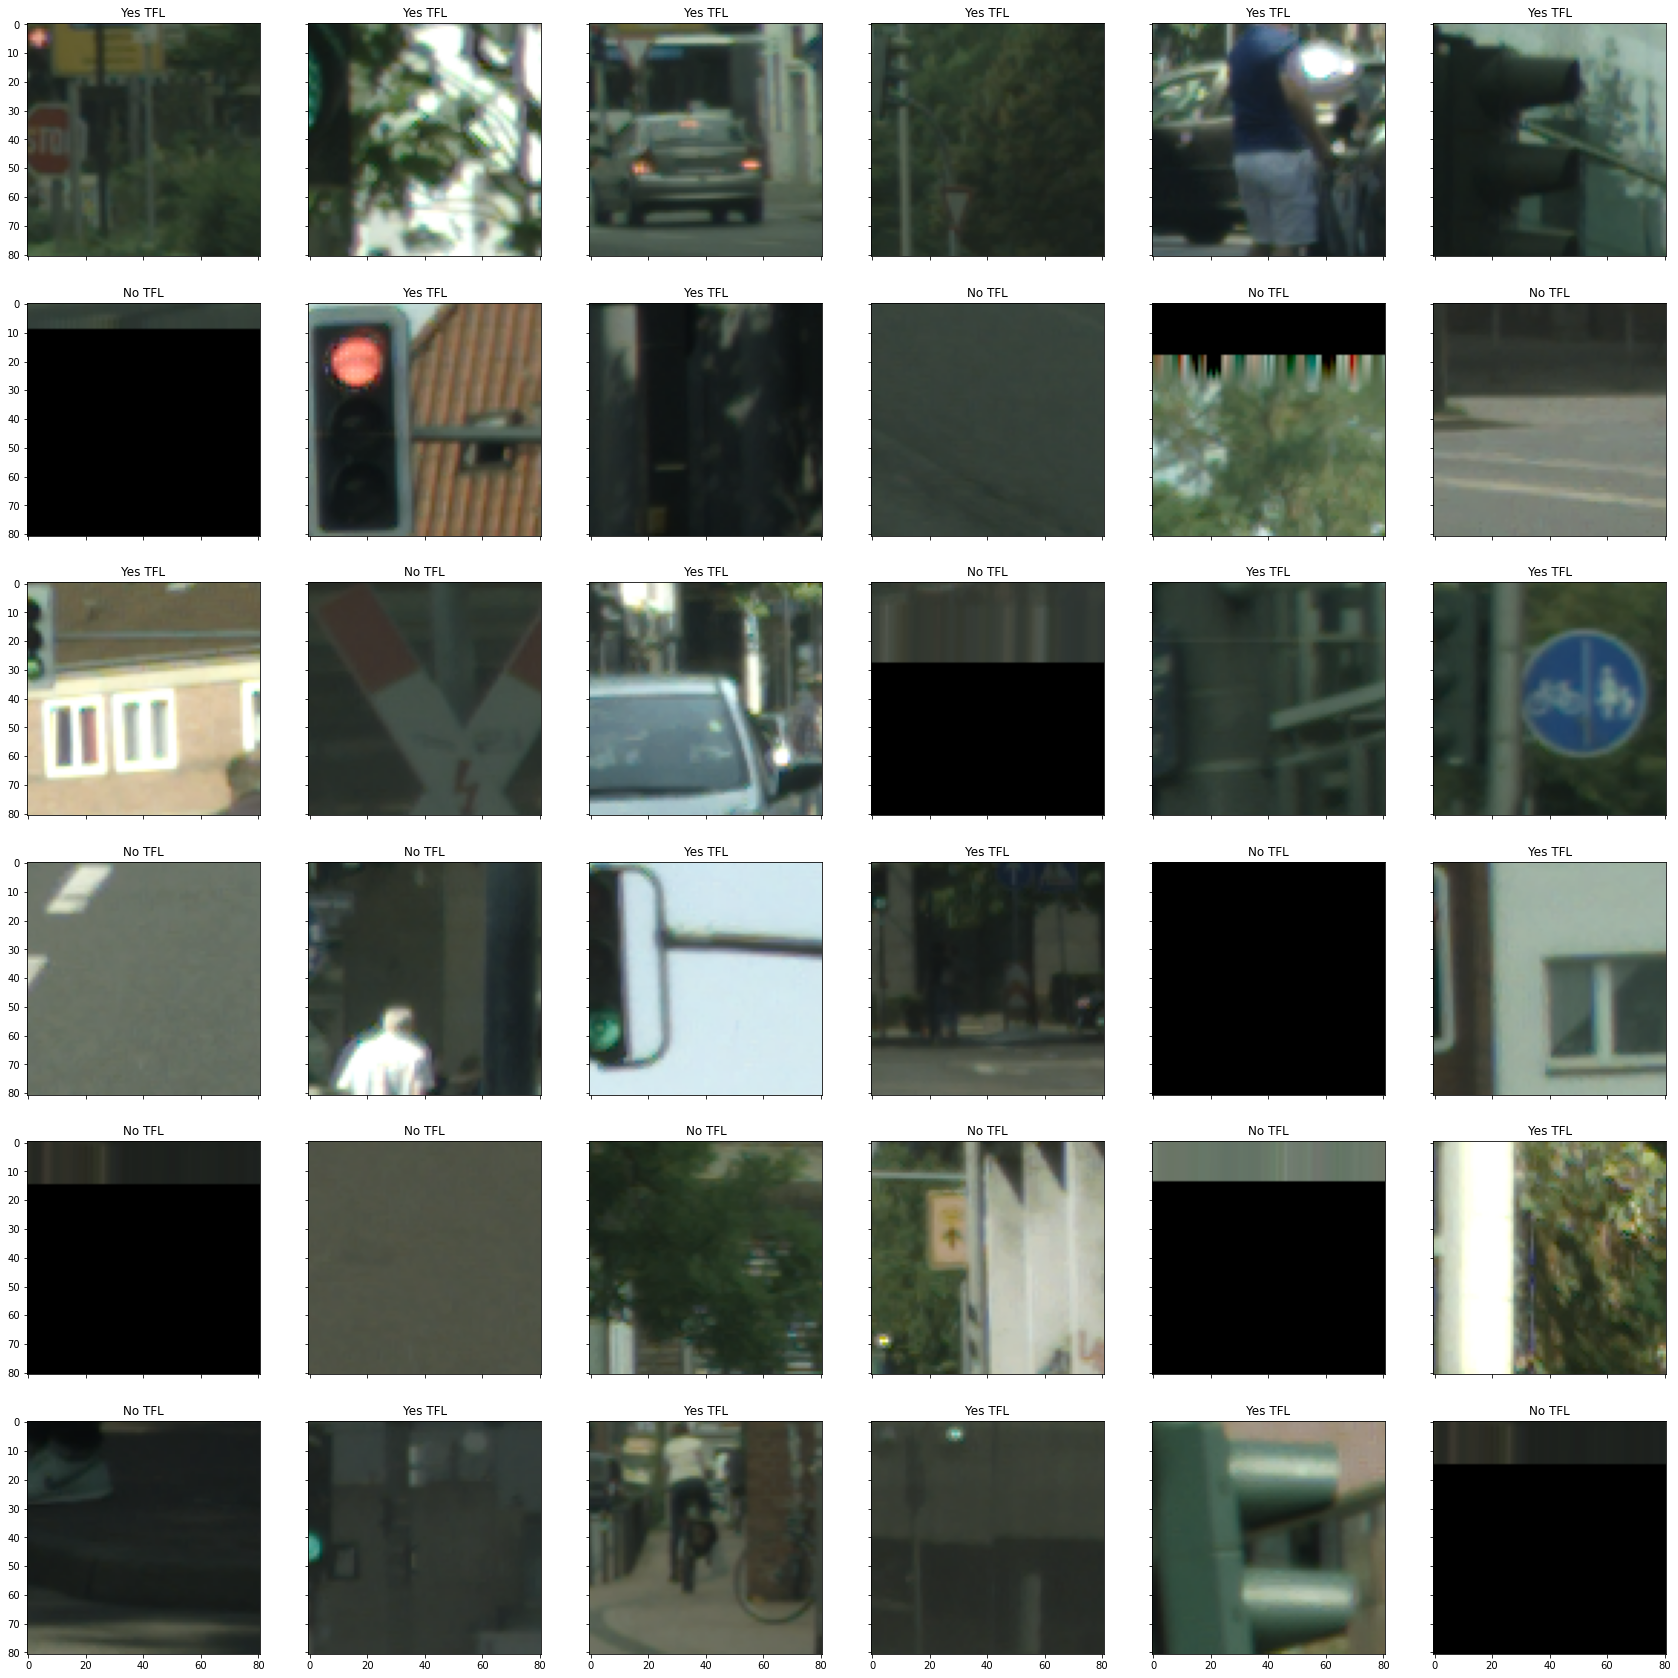

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   

# root = './'  #this is the root for your val and train datasets
data_dir = 'new'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D
from tensorflow.keras.layers import LSTM

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(25,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,16) 
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid'))
    spatial_layer(1,64)
    conv_bn_relu(16,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(2,12) 
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    
    model.add(Flatten())
    dense_bn_relu(40) 
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 79, 79, 25)        675       
_________________________________________________________________
batch_normalization_121 (Bat (None, 79, 79, 25)        100       
_________________________________________________________________
activation_121 (Activation)  (None, 79, 79, 25)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 77, 77, 16)        3600      
_________________________________________________________________
batch_normalization_122 (Bat (None, 77, 77, 16)        64        
_________________________________________________________________
activation_122 (Activation)  (None, 77, 77, 16)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 38, 38, 16)      

In [21]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Epoch 1/10
165/165 [==============================] - 160s 972ms/step - loss: 0.5535 - accuracy: 0.7248 - val_loss: 0.5538 - val_accuracy: 0.6967
Epoch 2/10
165/165 [==============================] - 168s 1s/step - loss: 0.4546 - accuracy: 0.7832 - val_loss: 0.5182 - val_accuracy: 0.7363
Epoch 3/10
165/165 [==============================] - 167s 1s/step - loss: 0.4133 - accuracy: 0.8162 - val_loss: 0.4219 - val_accuracy: 0.7967
Epoch 4/10
165/165 [==============================] - 168s 1s/step - loss: 0.3941 - accuracy: 0.8316 - val_loss: 0.3739 - val_accuracy: 0.8341
Epoch 5/10
165/165 [==============================] - 163s 990ms/step - loss: 0.3657 - accuracy: 0.8425 - val_loss: 0.3803 - val_accuracy: 0.8341
Epoch 6/10
165/165 [==============================] - 182s 1s/step - loss: 0.3534 - accuracy: 0.8411 - val_loss: 0.3945 - val_accuracy: 0.8132
Epoch 7/10
165/165 [==============================] - 189s 1s/step - loss: 0.3290 - accuracy: 0.8567 - val_loss: 0.4075 - val_accuracy: 

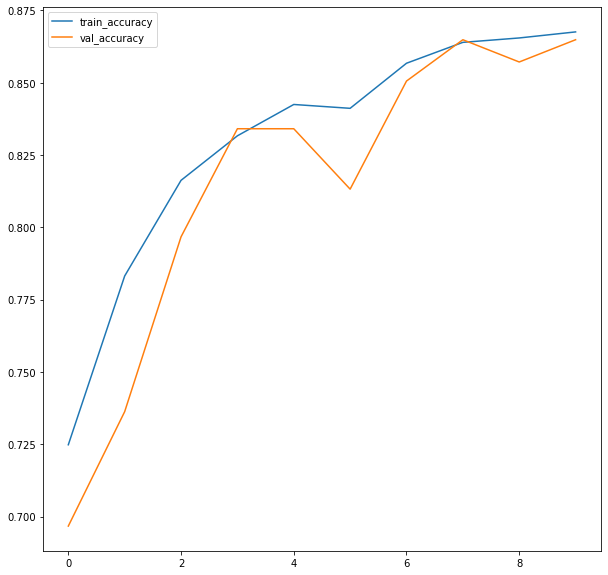

In [22]:
# compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

accuracy: 0.8648351648351649


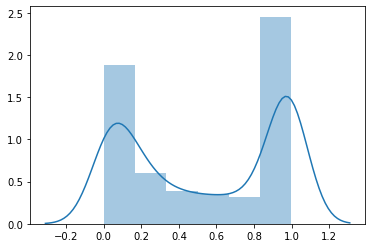

In [23]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

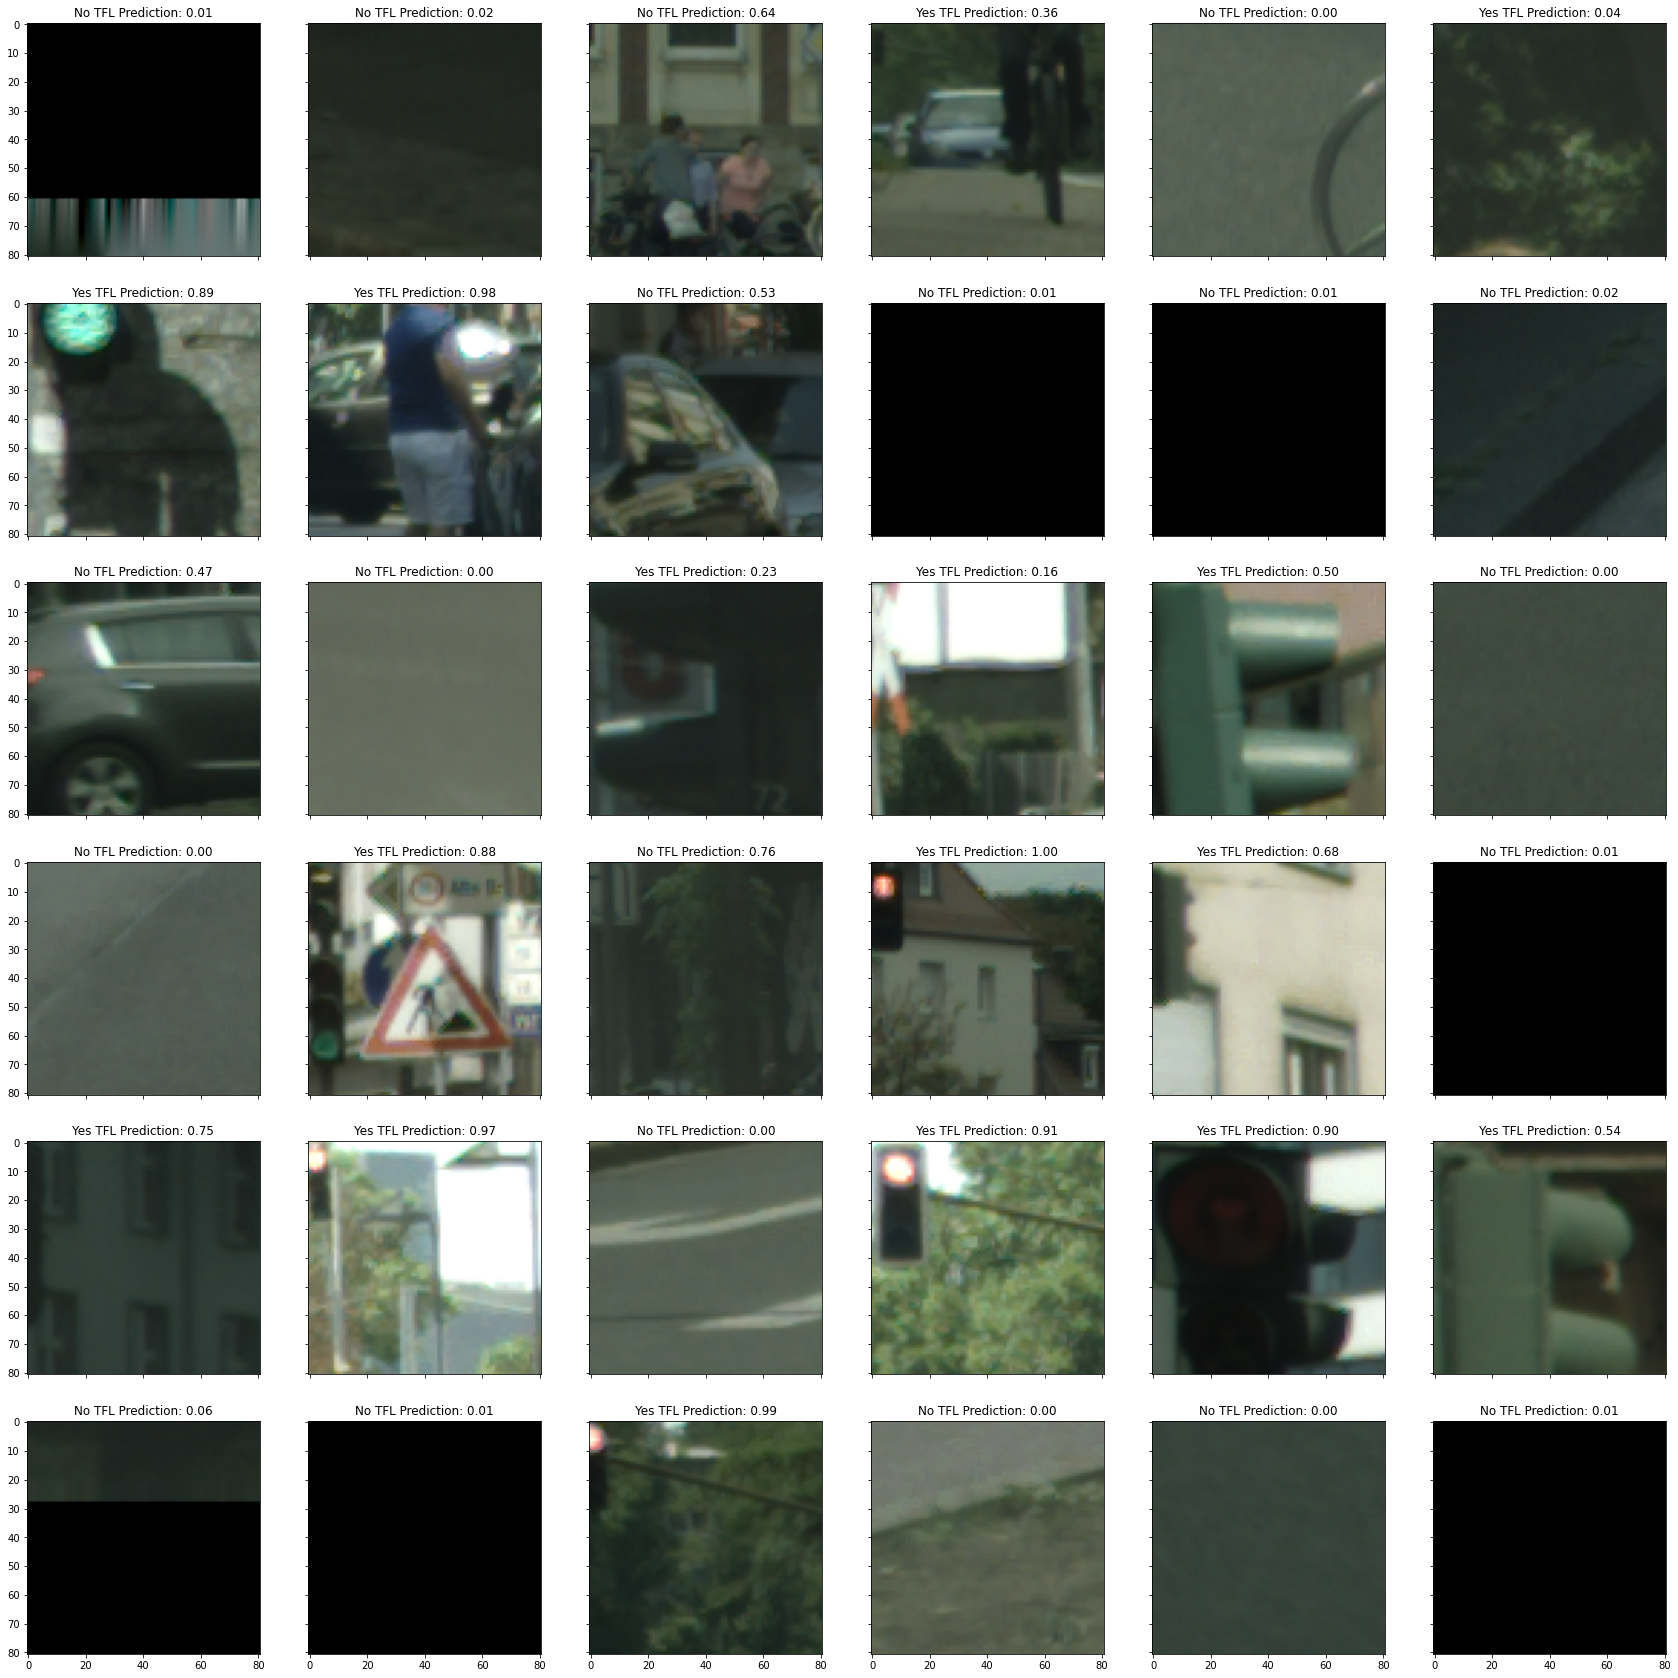

In [24]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

In [ ]:
m.save("model.h5")